# Popular Models

In [3]:
import cv2 as cv
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision.models import resnet50, ResNet50_Weights

## Usecase 1 - Pretrained Model for Inference, Retraining not Required

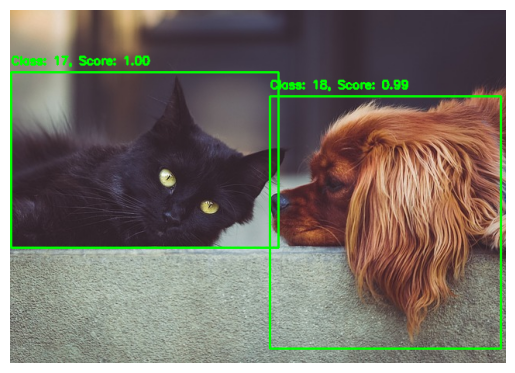

In [8]:
# Load a pre-trained Faster R-CNN model with Resnet backbone and FPN
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  

# Define image transformation
transform = T.Compose([T.ToTensor()])

# Load and preprocess the image using OpenCV
image_path = "data/images/image2.jpg"
image = cv.imread(image_path)
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB) 
image_tensor = transform(image_rgb)

# Perform inference
with torch.no_grad():
    predictions = model([image_tensor])

# Extract predictions for boxes, labels, and scores
predictions = predictions[0]
boxes = predictions['boxes']
labels = predictions['labels']
scores = predictions['scores']

# Set a confidence threshold to filter predictions
confidence_threshold = 0.5
filtered_indices = [i for i, score in enumerate(scores) if score > confidence_threshold]

# Draw bounding boxes and labels on the image
for i in filtered_indices:
    box = boxes[i].numpy()  # Get the box coordinates (x_min, y_min, x_max, y_max)
    label = labels[i].item()      # Get the class label
    score = scores[i].item()      # Get the confidence score

    # Draw the rectangle on the image (using OpenCV)
    x_min, y_min, x_max, y_max = box
    cv.rectangle(image_rgb, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
    
    # Add the label and score text to the image
    text = f"Class: {label}, Score: {score:.2f}"
    cv.putText(image_rgb, text, (int(x_min), int(y_min) - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image with bounding boxes using matplotlib
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

## Usecase 2 - Popular Backbone with Custom Fully Connected Layers

In [4]:
def generate_image_with_label():
    size = 100
    max_count = 20
    img = np.random.randint(0, 150, (size, size, 3), dtype="uint8")
    number = np.random.randint(0, max_count)
    centers = np.random.randint(0, size, (number, 2))
    radii = np.random.randint(3, 10, number)
    colors = np.random.randint(0, 255, (number, 3), dtype="int")
    for center, radius, color in zip(centers, radii, colors):
        cv.circle(img, center, radius, list(map(int, color)), -1)
    return img, number

In [13]:
class BlobDataset(Dataset):
    
    def __init__(self, data, labels, device="cpu"):
        self._transform = T.Compose([
            T.ToTensor(),  # Convert the image to a tensor with values [0, 1]
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
        ])
        self.inputs = [self._transform(img) for img in data]
        self.targets = [torch.tensor(y).float() for y in labels]
        self._device = device

    def __len__(self):
        # Number of samples in the dataset
        return len(self.inputs)
    
    def __getitem__(self, idx):
        # Return a single sample at the given index
        return self.inputs[idx].to(self._device), self.targets[idx].to(self._device)

In [9]:
class BlobCounterV2(nn.Module):
    def __init__(self):
        super(BlobCounterV2, self).__init__()
        
        self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.fc_in_features = self.resnet.fc.in_features
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        num_features = 256
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features, num_features * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(num_features * 2, num_features),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(num_features, 1),
            nn.ReLU(),
        )

    def forward(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return self.fc(output).squeeze(-1)


Epoch [0/40], Training Loss: 516.50171,  Validation Loss: 81.07356, "MAE: 5.096
Epoch [1/40], Training Loss: 193.58376,  Validation Loss: 244.37724, "MAE: 8.472
Epoch [2/40], Training Loss: 177.33002,  Validation Loss: 27.09190, "MAE: 3.064
Epoch [3/40], Training Loss: 83.04729,  Validation Loss: 24.98777, "MAE: 2.847
Epoch [4/40], Training Loss: 60.98740,  Validation Loss: 17.33031, "MAE: 2.273
Epoch [5/40], Training Loss: 42.57612,  Validation Loss: 14.85803, "MAE: 2.119
Epoch [6/40], Training Loss: 28.57382,  Validation Loss: 12.15854, "MAE: 2.012
Epoch [7/40], Training Loss: 32.39215,  Validation Loss: 26.81726, "MAE: 2.796
Epoch [8/40], Training Loss: 34.64677,  Validation Loss: 11.55598, "MAE: 1.905
Epoch [9/40], Training Loss: 20.71099,  Validation Loss: 9.13292, "MAE: 1.723
Epoch [10/40], Training Loss: 15.30287,  Validation Loss: 12.23081, "MAE: 1.993
Epoch [11/40], Training Loss: 27.13791,  Validation Loss: 11.40170, "MAE: 1.993
Epoch [12/40], Training Loss: 15.93400,  Valida

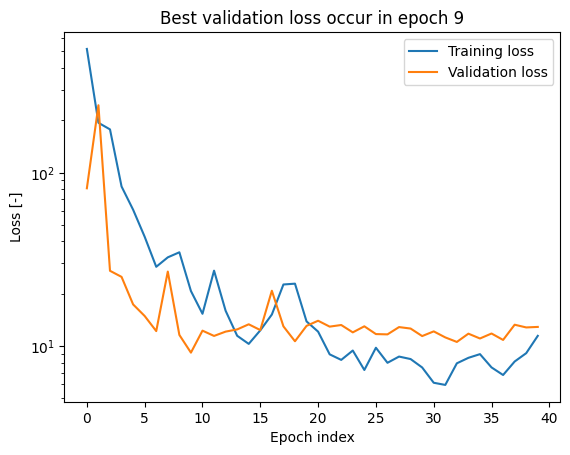

In [19]:
epochs = 40
batch_size = 32
device = "cuda"

np.random.seed(101)
data_all, labels_all = zip(*[generate_image_with_label() for idx in range(300)])
data_train, data_val, labels_train, labels_val = train_test_split(data_all, labels_all, test_size=0.2, random_state=101)

train_dataset = BlobDataset(data_train, labels_train, device=device)
val_dataset = BlobDataset(data_val, labels_val, device=device)


model = BlobCounterV2().to(device)

criterion = nn.MSELoss()  # For regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    model.train()
    for train_inputs, train_targets in train_dataloader:
        train_outputs = model(train_inputs)
        train_loss = criterion(train_outputs, train_targets)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses[epoch] += train_loss
        
    model.eval()
    errors = []
    for val_inputs, val_targets in val_dataloader:
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_targets)
        
        val_losses[epoch] += val_loss
        errors.append(np.abs(val_targets.to("cpu").numpy() - val_outputs.detach().to("cpu").numpy()))
    mae = np.concatenate(errors).mean()

    if epoch % 1 == 0:
        print(f'Epoch [{epoch}/{epochs}], Training Loss: {train_losses[epoch]:.5f},  Validation Loss: {val_losses[epoch]:.5f}, "MAE: {mae:.3f}')


plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title(f"Best validation loss occur in epoch {val_losses.argmin()}")
plt.xlabel("Epoch index")
plt.ylabel("Loss [-]")
plt.yscale('log')
plt.show()